<a href="https://colab.research.google.com/github/cagBRT/Machine-Learning/blob/master/FeatureSelection1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
# Clone the entire repo.
!git clone -l -s https://github.com/cagBRT/Machine-Learning.git cloned-repo
%cd cloned-repo
!ls

Cloning into 'cloned-repo'...
remote: Enumerating objects: 72, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 950 (delta 27), reused 3 (delta 1), pack-reused 878
Receiving objects: 100% (950/950), 53.47 MiB | 10.71 MiB/s, done.
Resolving deltas: 100% (580/580), done.
/content/cloned-repo/cloned-repo/cloned-repo/cloned-repo
 Admission_Predict.csv		       LogisticRegression_1.ipynb
 bank.csv			       Logistic_Regression_3.ipynb
 bank-full.csv			       Logistic_Regression_4.ipynb
 blue_line.jpg			       LogReg_Titanic.ipynb
 boston_housing.csv		       Mall_Customers.csv
 breast_cancer_data.csv		       movies_df.csv
 cardata.data			       NaiveBayesBernoulli.ipynb
 cows_and_wolves.txt		       NaiveBayesGaussian2.ipynb
 CrossValidation.ipynb		       NaiveBayesGaussian.ipynb
 datasets_478_974_mushrooms.csv        NaiveBayesMultinomialNB2.ipynb
 diabetesML.ipynb		       NaiveBayesMultinomialNB.ipynb
 dogOrMuffin.ipynb		      

In [7]:
from IPython.display import Image
def page(num):
    return Image("images/fs"+str(num)+ ".png" , width=640)

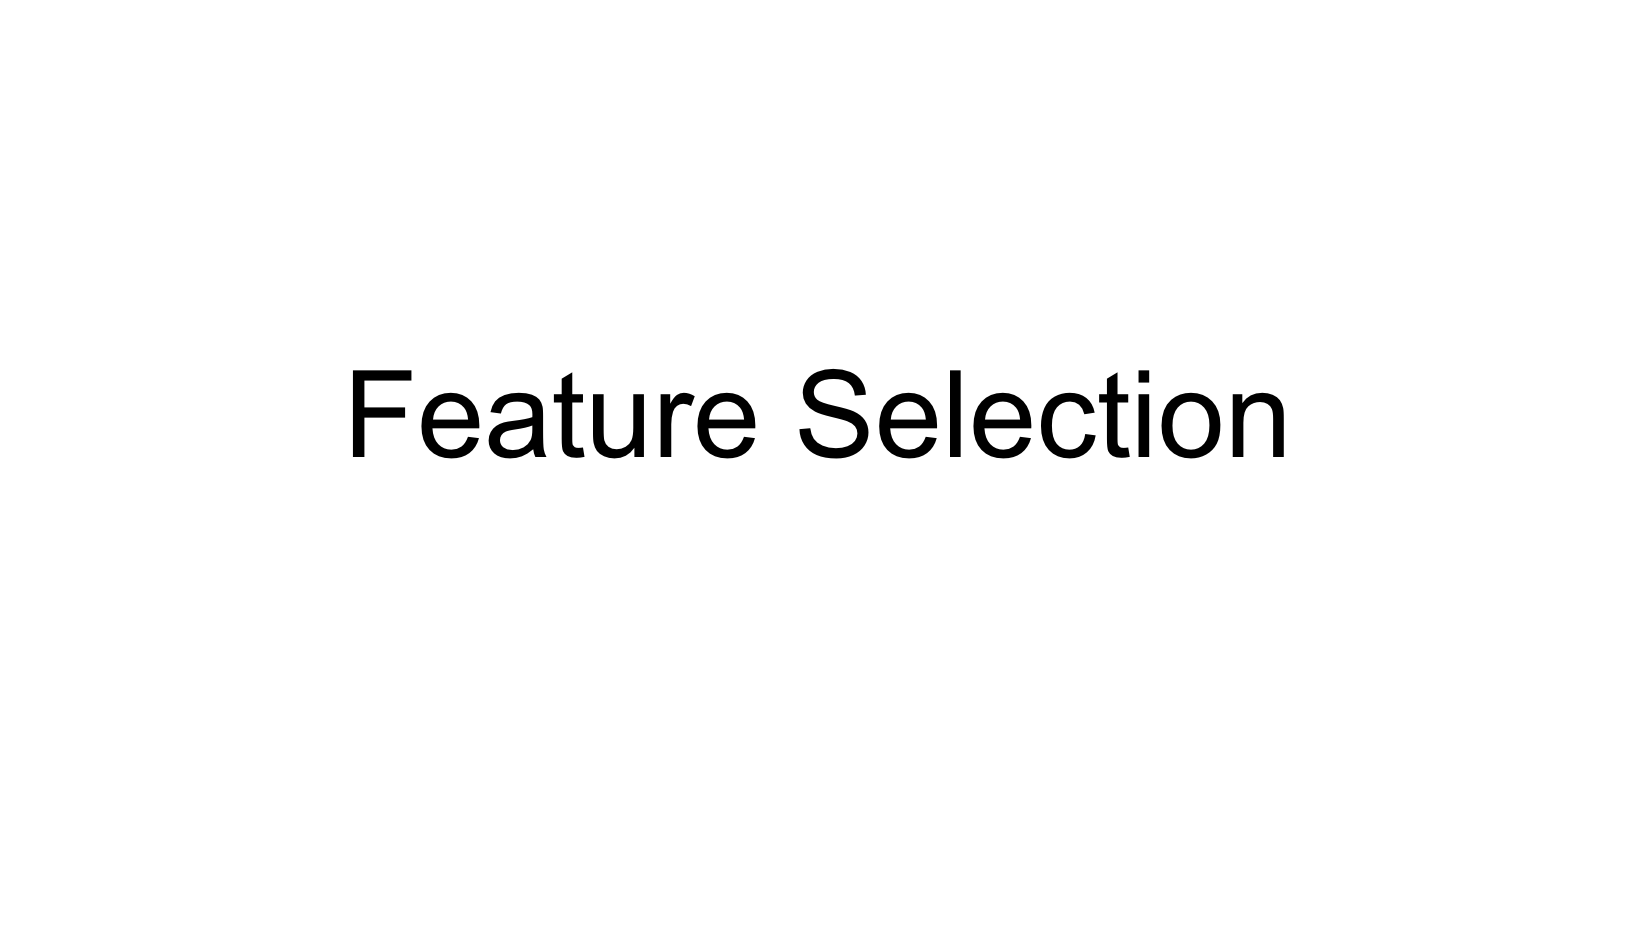

In [8]:
page(1)

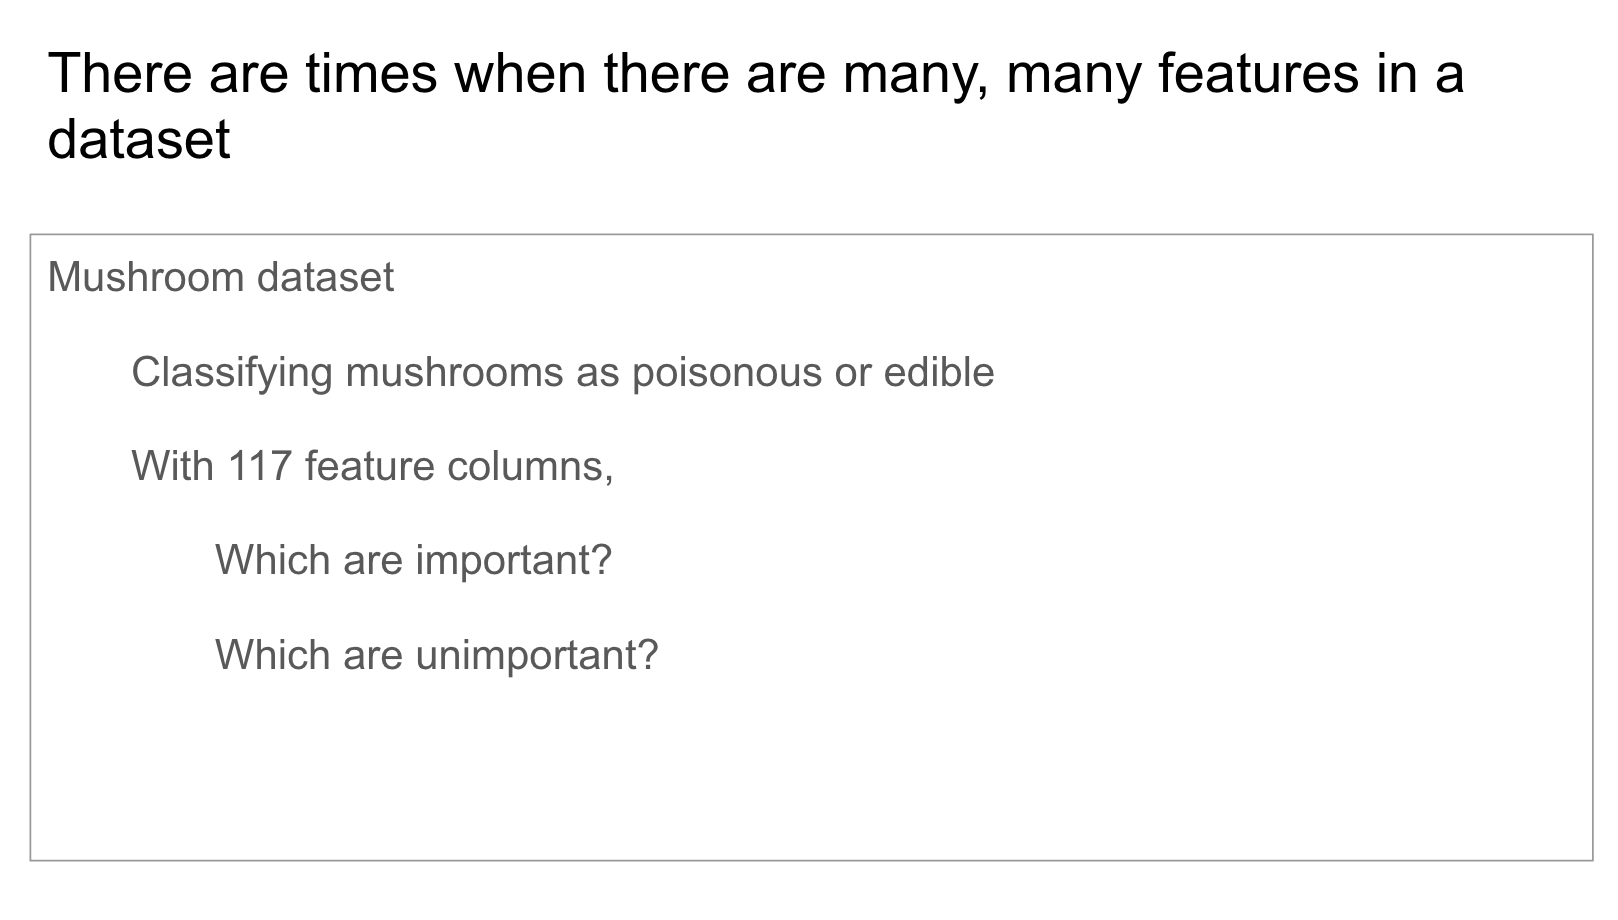

In [9]:
page(2)

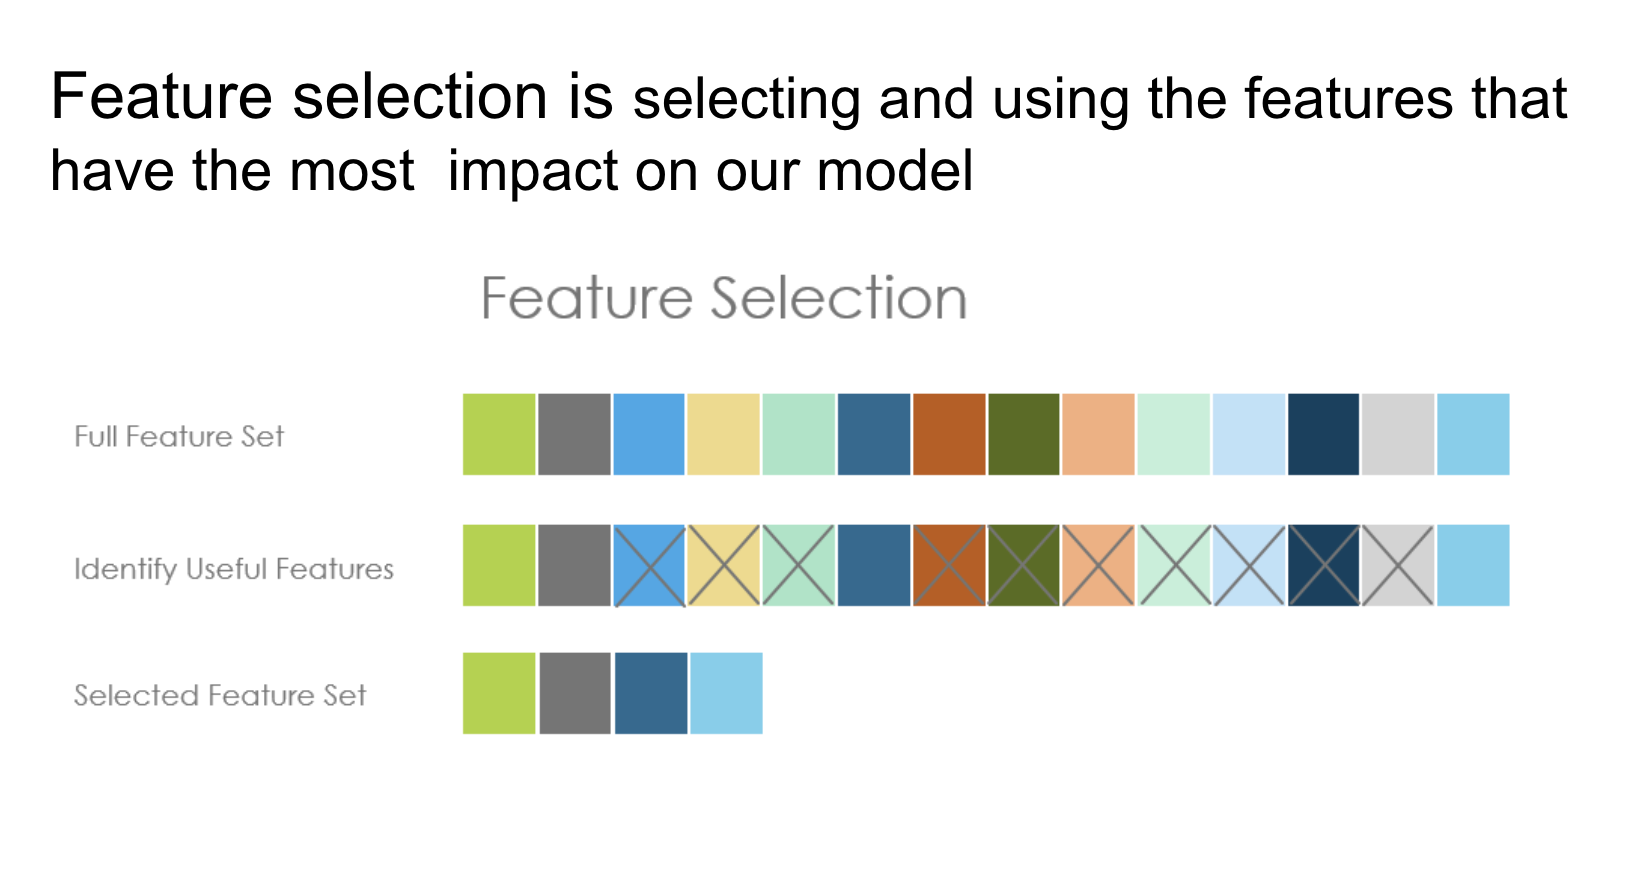

In [10]:
page(3)

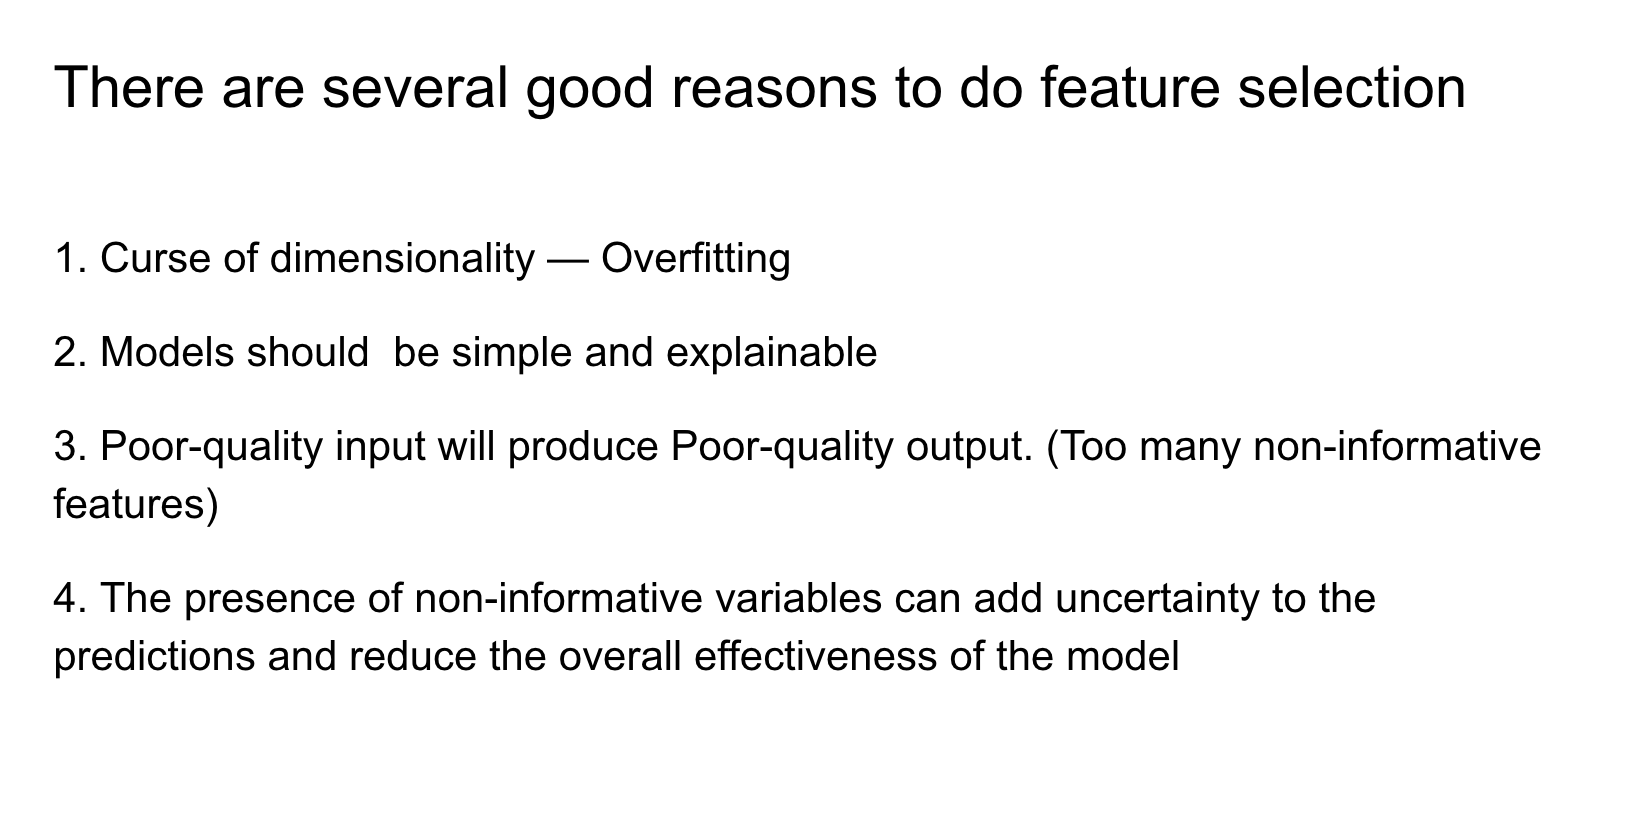

In [11]:
page(4)

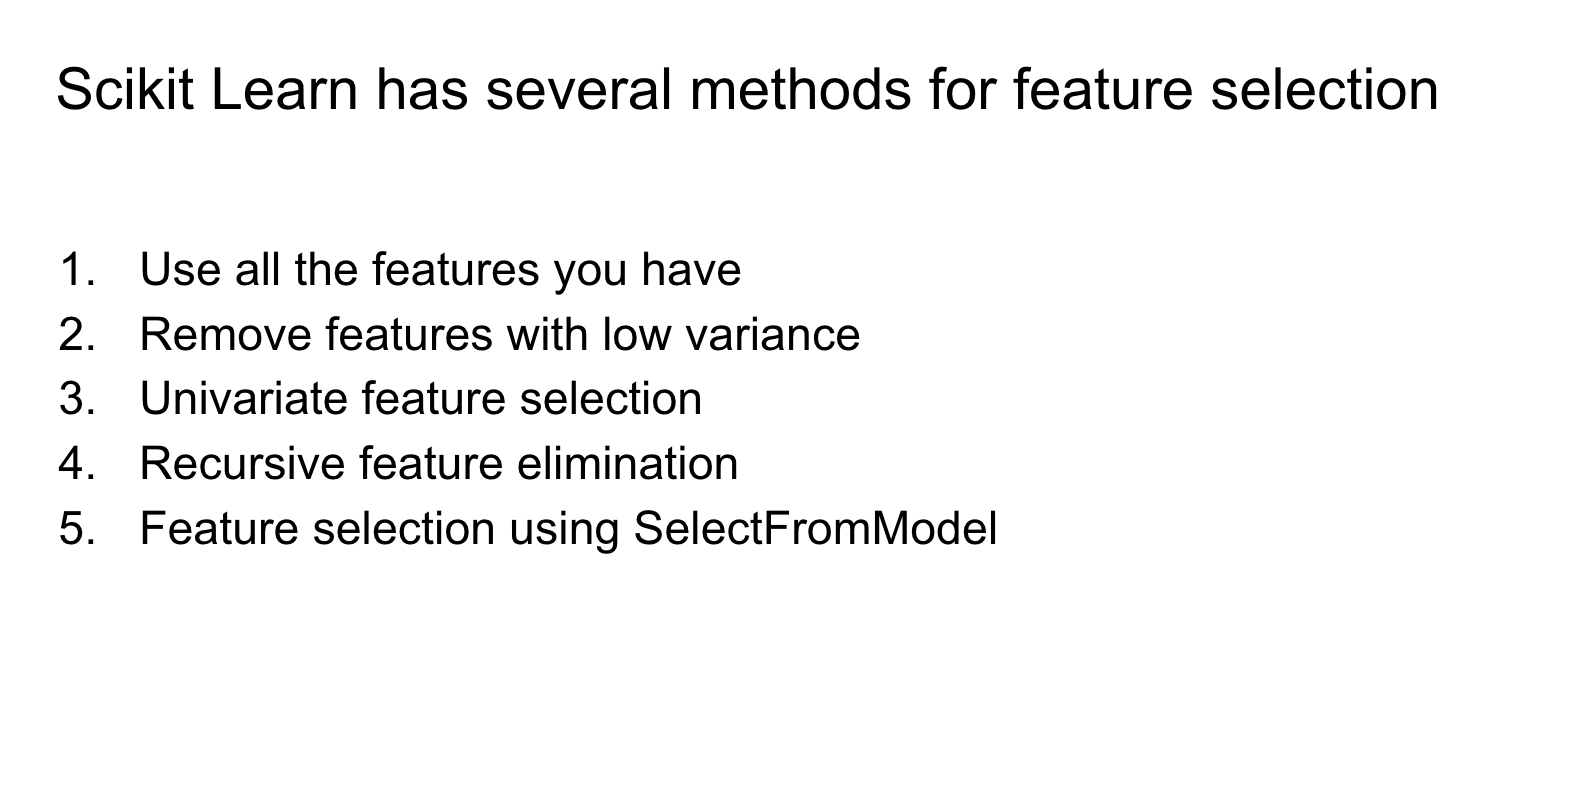

In [12]:
page(5)

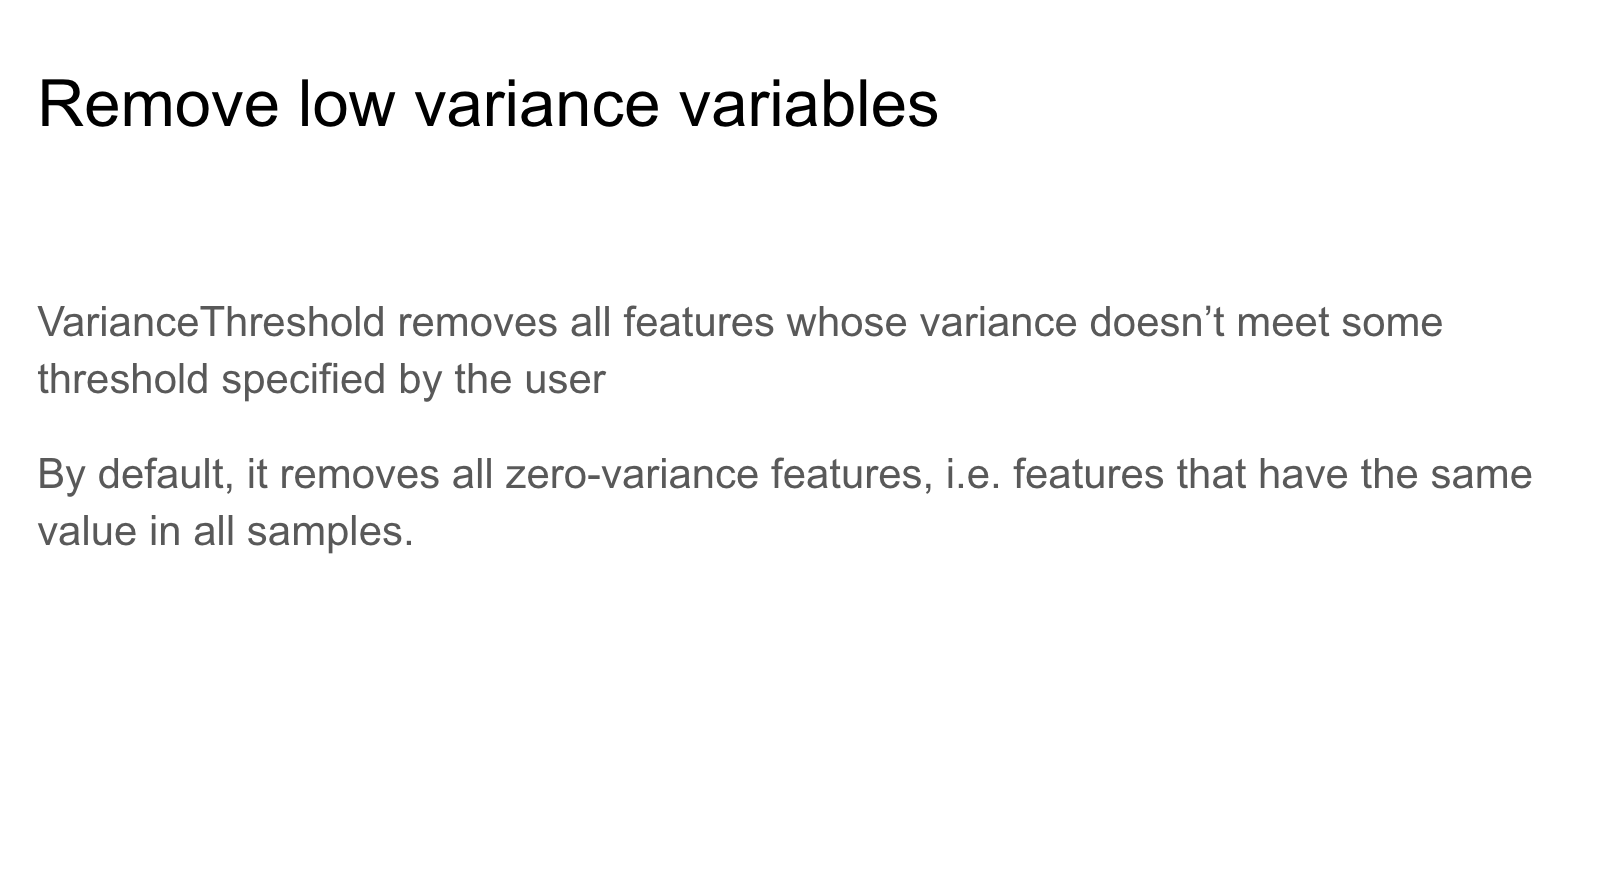

In [13]:
page(6)

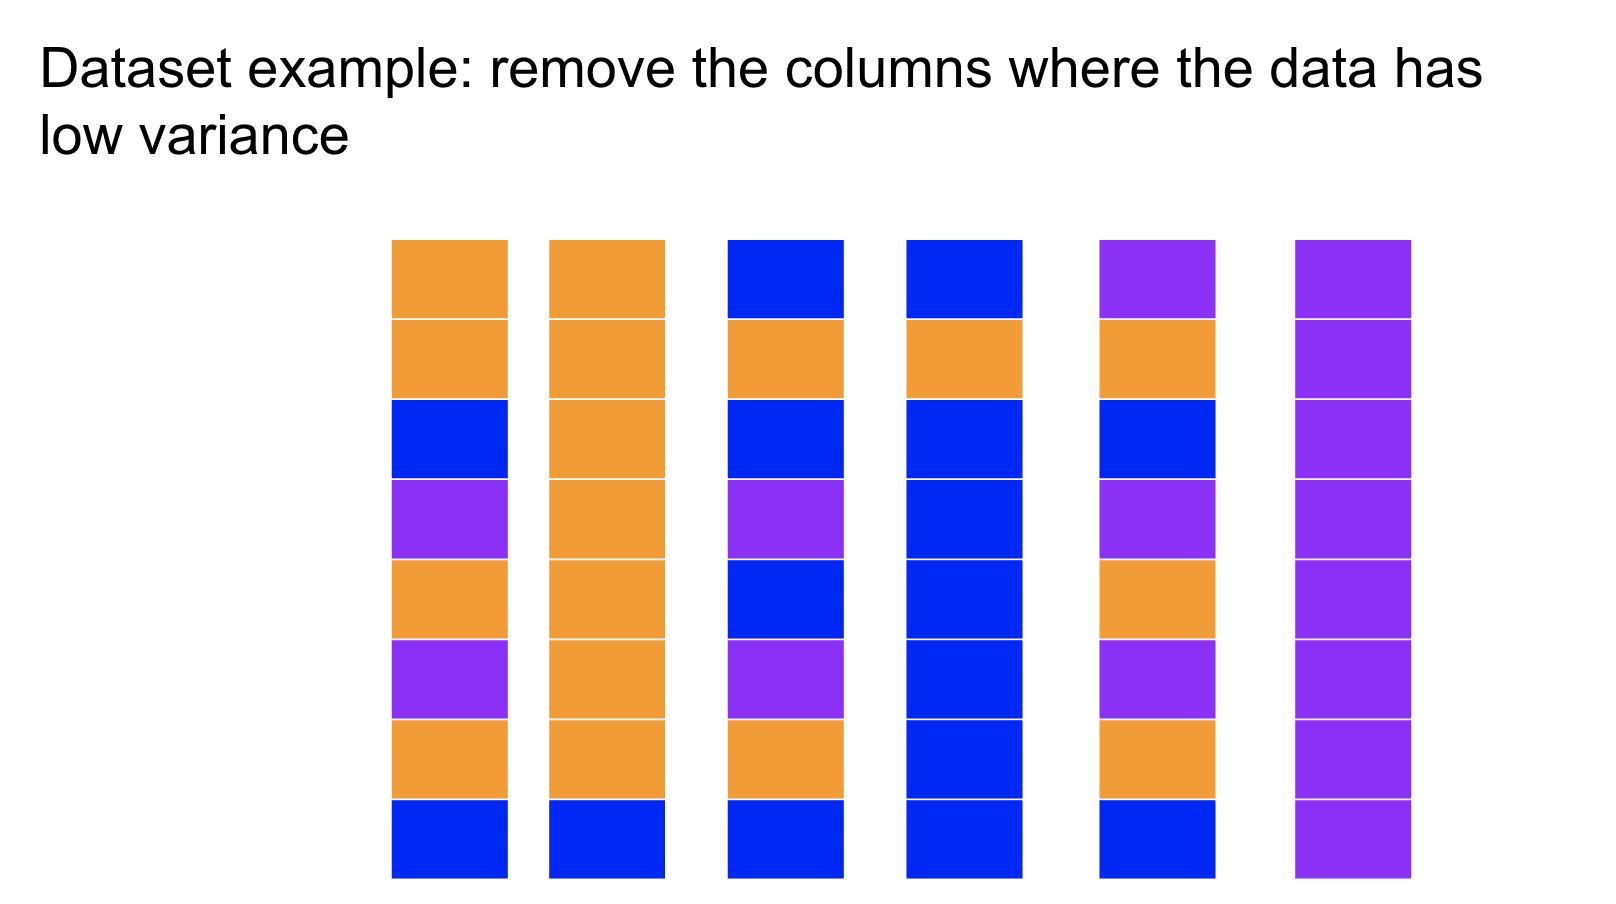

In [14]:
page(7)

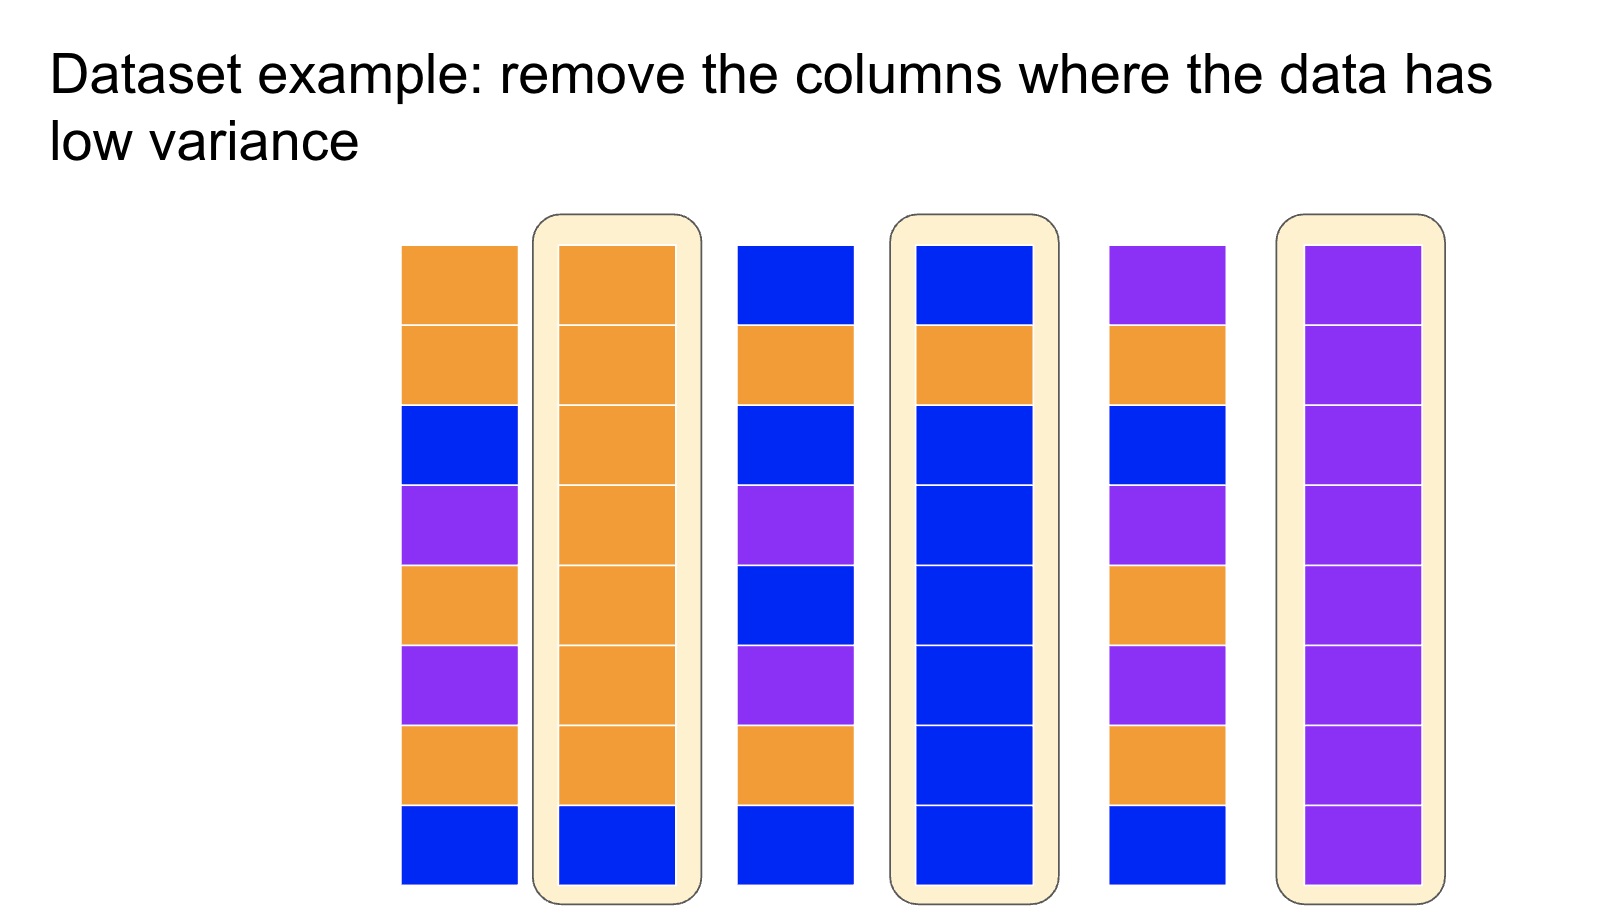

In [15]:
page(8)

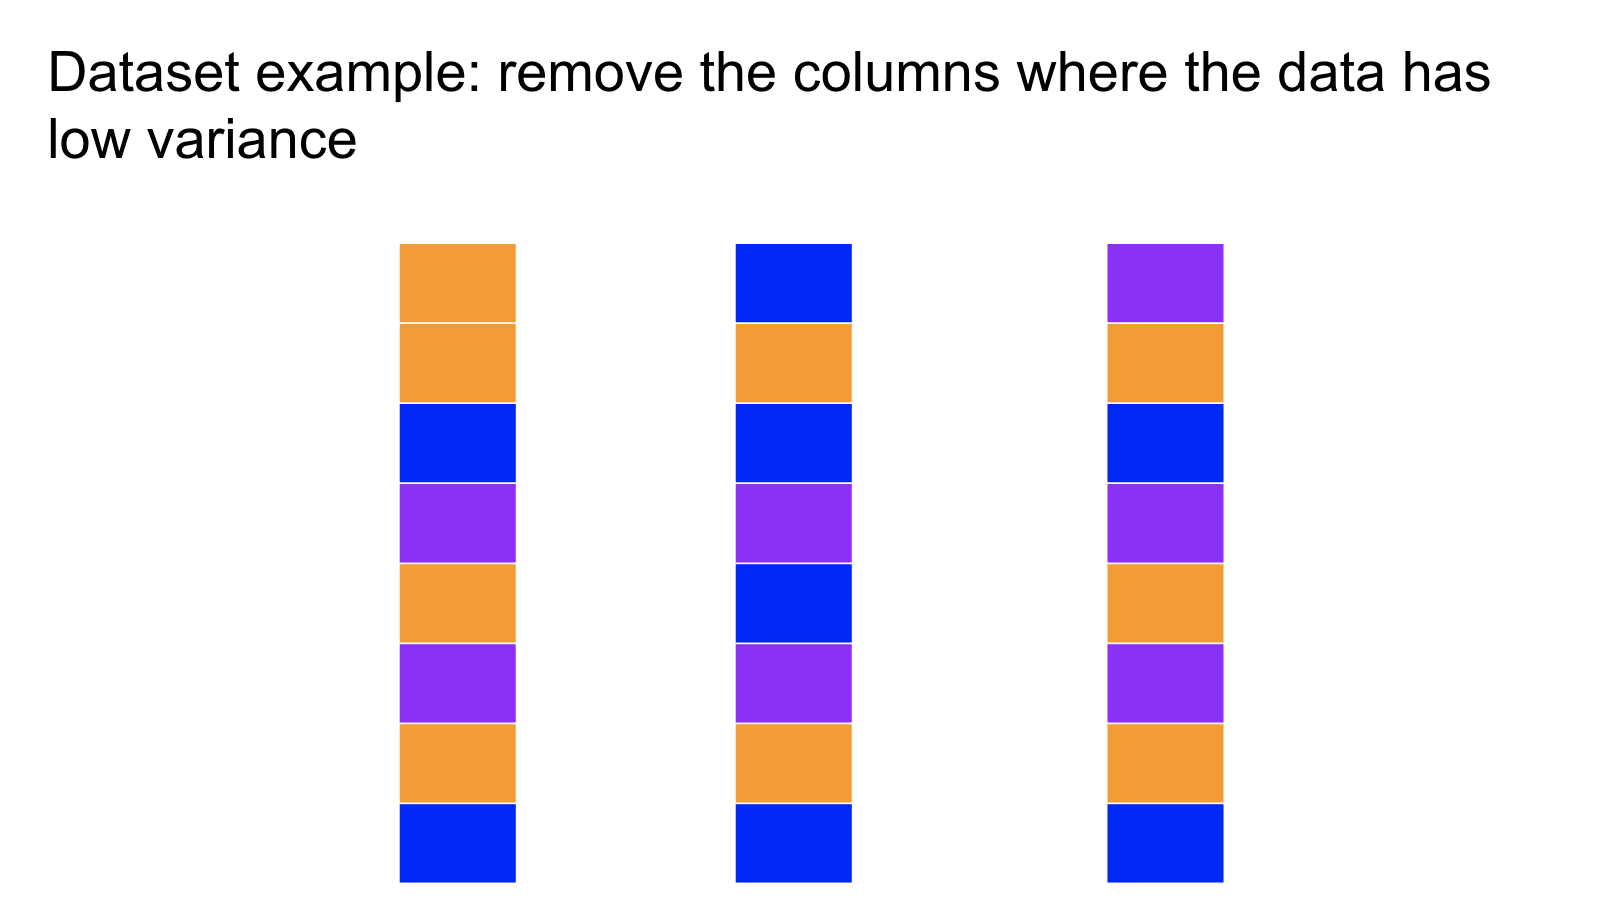

In [16]:
page(9)

# **Remove features with low variance**

As an example, suppose that we have a dataset with boolean features, and we want to remove all features that are either one or zero (on or off) in more than 80% of the samples. Any data where 80% of the data is the same is considered low variance data. <br>

Features with a training-set variance lower than this threshold will be removed. <br>
**The default is to keep all features with non-zero variance**, i.e. remove the features that have the same value in all samples.


Create a datasest with 3 features

In [17]:
from sklearn.feature_selection import VarianceThreshold
X = [[0, 0, 1], [0, 1, 0], [1, 0, 0], [0, 1, 1], [0, 1, 0], [0, 1, 1]]
print(X)

[[0, 0, 1], [0, 1, 0], [1, 0, 0], [0, 1, 1], [0, 1, 0], [0, 1, 1]]


Remove all variables where the variance does not meet the threshold

As expected, VarianceThreshold has removed the first column, 
which had 0,0,1,0,0,0 <br>
There is very little variance in this column, so it will not add much information for our model to use when making predictions. So remove this column.  

In [18]:
sel = VarianceThreshold(threshold=(0.16))
sel.fit_transform(X)

array([[0, 1],
       [1, 0],
       [0, 0],
       [1, 1],
       [1, 0],
       [1, 1]])

# **Assignment 1**
Remove any low variance data from the given dataset.<br>
<br>
[[0,1,2,0,2],[2,2,1,0,1],[1,1,1,0,1],[0,2,1,0,0],[2,1,1,0,0],[1,1,2,0,0],[2,2,0,0,1],[1,0,1,0,1],[0,2,1,0,1],[2,1,1,1,0],[0,1,1,0,2],[1,2,0,0,1],[2,1,1,2,1],[2,0,1,0,1]]

1. Find the lowest threshold that still produces a change in the dataset
2. Find the threshold to remove a second feature column

In [19]:
#Assignment 1
xx = [[0,1,2,0,2],[2,2,1,0,1],[1,1,1,0,1],[0,2,1,0,0],[2,1,1,0,0],[1,1,2,0,0],[2,2,0,0,1],[1,0,1,0,1],[0,2,1,0,1],[2,1,1,1,0],[0,1,1,0,2],[1,2,0,0,1],[2,1,1,0,1],[2,0,1,0,1]]


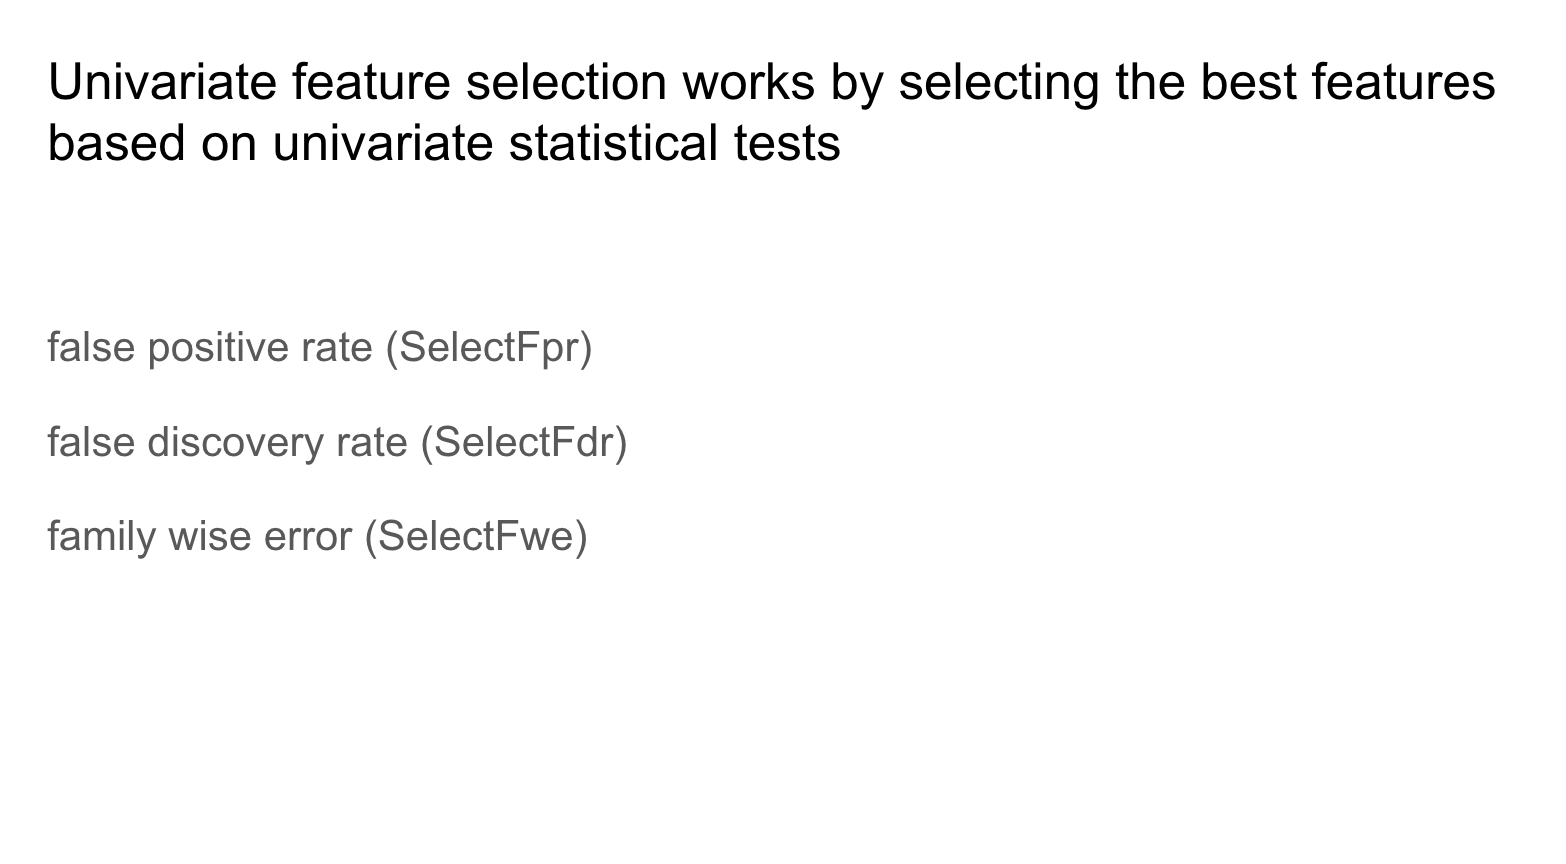

In [21]:
page(10)

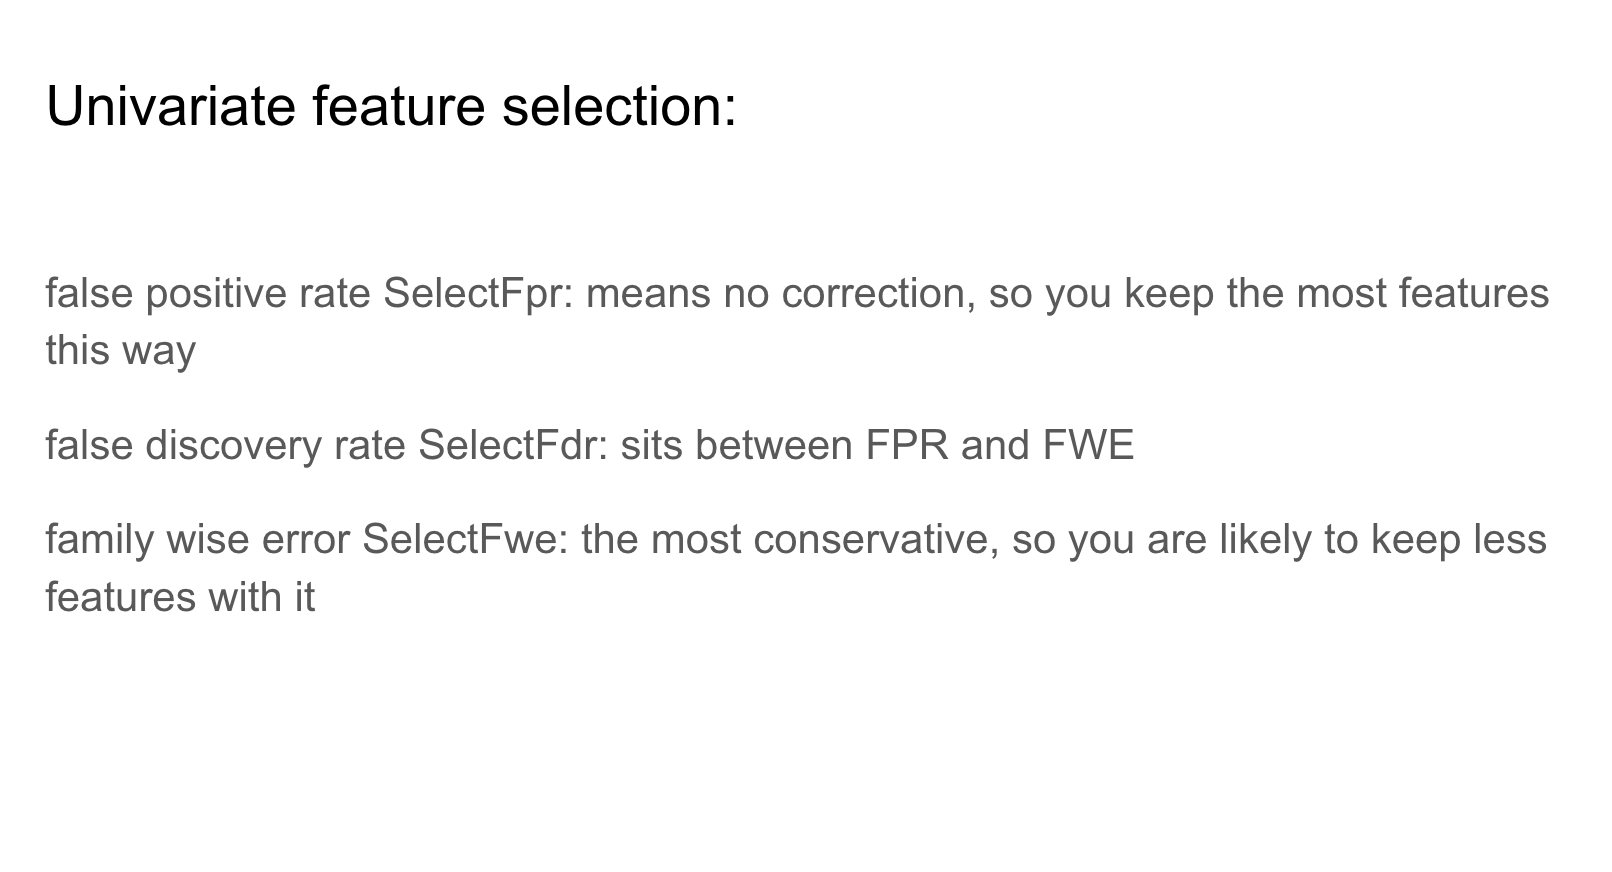

In [25]:
page(13)

# **Univariate feature selection**

>SelectKBest removes all but the k highest scoring features<br>
<br>
SelectPercentile removes all but a user-specified highest scoring percentage of features<br>
<br>
Uses common univariate statistical tests for each feature:<br> 
* false positive rate SelectFpr<br>
* false discovery rate SelectFdr<br>
* family wise error SelectFwe<br>
* genericUnivariateSelect - selects the best strategy with a hyper parameter search estimator

**Example 1:**

SelectKBest removes all but the *k* highest scoring features

Get the Iris dataset

In [ ]:
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
X, y = load_iris(return_X_y=True)
X.shape

These functions take as input a scoring function that returns univariate scores and p-values (or only scores for SelectKBest and SelectPercentile)<br>
For regression use: f_regression, mutual_info_regression

For classification use: chi2, f_classif, mutual_info_classif
<br><br>
Then select the highest scoring features

In [ ]:
#Use chi2 to score the the columns. Select the two columns that have the highest scores
X_new = SelectKBest(chi2, k=2).fit_transform(X, y)
X_new.shape

**Example 2: Check model performance after variable selection**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif

**Get data and add noise to the dataset**

As an experiment, use the Iris dataset, but add noise to it so that it has 24 features. 

In [ ]:
# Import the Iris dataset
X, y = load_iris(return_X_y=True)

# Some noisy data not correlated
E = np.random.RandomState(42).uniform(0, 0.1, size=(X.shape[0], 20))

# Add the noisy data to the informative features
X = np.hstack((X, E))
X.shape


**Do the train-test split**

In [ ]:
# Split dataset to select feature and evaluate the classifier
X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, random_state=0
)

**Create an SVM model and train it on all the features**

In [ ]:
# Compare to the weights of an SVM
clf = make_pipeline(MinMaxScaler(), LinearSVC())
clf.fit(X_train, y_train)
print('Classification accuracy without selecting features: {:.3f}'
      .format(clf.score(X_test, y_test)))

svm_weights = np.abs(clf[-1].coef_).sum(axis=0)
svm_weights /= svm_weights.sum()

**Create an SVM and train it with only the selected features**

In [ ]:
# #############################################################################
# Using the SelectKBest function, select the best 4 best features to keep
# #############################################################################

selector = SelectKBest(f_classif, k=4)
selector.fit(X_train, y_train)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()

In [ ]:
clf_selected = make_pipeline(
        SelectKBest(f_classif, k=4), MinMaxScaler(), LinearSVC()
)
clf_selected.fit(X_train, y_train)
print('Classification accuracy after univariate feature selection: {:.3f}'
      .format(clf_selected.score(X_test, y_test)))

svm_weights_selected = np.abs(clf_selected[-1].coef_).sum(axis=0)
svm_weights_selected /= svm_weights_selected.sum()

It is clear the model that used only the highest scoring SelectKBest values has a higher performance. 

In [ ]:
X_indices = np.arange(X.shape[-1])
plt.figure(1)
plt.figure(figsize=(20,5))
plt.clf()

plt.bar(X_indices - .45, scores, width=.2,
        label=r'Univariate score ($-Log(p_{value})$)')

plt.bar(X_indices - .25, svm_weights, width=.2, label='SVM weight')

plt.bar(X_indices[selector.get_support()] - .05, svm_weights_selected,
        width=.2, label='SVM weights after selection')

plt.title("Comparing feature selection")
plt.xlabel('Feature number')
plt.yticks(())
plt.axis('tight')
plt.legend(loc='upper right')
plt.show()

# **Assignment 2**
The plot above shows two of the univariate scores are much higher that the other scores. <br>
Train the model using only the two highest scores. <br>
Does the model performance get better or worse?

In [ ]:
#Assignment 2


# **Recursive feature elimination**

Select features by recursively considering smaller and smaller sets of features


A recursive feature elimination example showing the relevance of pixels in a digit classification task

In [ ]:
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std
import numpy as np 
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

**Load the digits dataset (classification)**.<br>

Each datapoint is a 8x8 image of a digit.<br>
>Classes: 10<br>
>Samples per class: ~180<br>
>Samples total: 1797<br>
>Dimensionality: 64<br>
>Features: integers 0-9

In [ ]:
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.data.shape)

In [ ]:
X = digits.images.reshape((len(digits.images), -1))
y = digits.target

Look at one of the digits, the number 9

In [ ]:
choice = 2
plt.gray() 
plt.matshow(digits.images[choice]) 
plt.show() 

There are 64 pixels in the image. <br>
Which ones are important to the model and which ones can we prune?

In [ ]:
X[choice]

In [ ]:
y[choice]

Create the Recursive Feature Elimination (RFE) object and rank each pixel

In [ ]:
svc = SVC(kernel="linear", C=1)
rfe = RFE(estimator=svc, n_features_to_select=1, step=1)
rfe.fit(X, y)
ranking = rfe.ranking_.reshape(digits.images[0].shape)

List the ranks assigned to each pixel. <br>
The higher the ranking corresponds to which should be pruned first. 

In [ ]:
ranking

Plot pixel ranking

In [ ]:
plt.matshow(ranking, cmap=plt.cm.Blues)
plt.colorbar()
plt.title("Ranking of pixels with RFE")
plt.show()

# **Assignment 3**
Right now the model is saving only one pixel. Change the number of pixels saved to 48 pixels. <br>
Rerun the ranking of the pixels. <br>
Then run the code below.<br>
Which pixels were removed? <br>
After removing the pixels compare the performance of the reduced pixel images to the performance of the full image. <br>
How much of a difference is there in the accuracy scores?

The model with all but one feature removed.

In [ ]:
model = DecisionTreeClassifier()
#List of (name, transform) tuples (implementing fit/transform) that are chained, 
#in the order in which they are chained, with the last object an estimator.
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
pipeline.fit(X, y)
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

The model with all features used.

In [ ]:
model.fit(X, y)
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

**RFE Example  2**

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

**Create the data with 3 informative features and 25 features total**

In [ ]:
# Build a classification task using 3 informative features
X2, y2 = make_classification(n_samples=1000, n_features=25, n_informative=3,
                           n_redundant=2, n_repeated=0, n_classes=8,
                           n_clusters_per_class=1, random_state=0)

**Create the RFE object**<br>
Using a cross-validated score, recursively eliminate the less important features

In [ ]:
# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2),
              scoring='accuracy')
rfecv.fit(X2, y2)

print("Optimal number of features : %d" % rfecv.n_features_)

**Plot the score vs number of features selected**<br>
The validation score drops as the number of non-informative features increases. <br>
We know that the data we created has 3 informative features and 25 features total, so this agrees with what we expect. 

In [ ]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

# **Assignment 4**
The following example uses a dataset from a Kaggle competition. <br>
The training set has 250 rows and 302 columns of data. <br>
The example will use RFE to determine which columns (or features) are actually informative. 

Your assignment, determine how many features should be kept of the 302 available?

In [ ]:
# setting up default plotting parameters
%matplotlib inline

plt.rcParams['figure.figsize'] = [20.0, 7.0]
plt.rcParams.update({'font.size': 22,})

sns.set_palette('viridis')
sns.set_style('white')
sns.set_context('talk', font_scale=0.8)

In [ ]:
train = pd.read_csv('featureSelectTrain.csv')
test = pd.read_csv('featureSelectTest.csv')

print('Train Shape: ', train.shape)
print('Test Shape: ', test.shape)

train.head()

In [ ]:
# prepare for modeling
X_train_df = train.drop(['id', 'target'], axis=1)
y_train = train['target']

X_test = test.drop(['id'], axis=1)

# scaling data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_df)
X_test = scaler.transform(X_test)

In [ ]:
y_train

Using the built-in method cumsum, there are 67 rows with the label '1' and 183 with the label '0'

In [ ]:
y_train.cumsum()

Since there are two classes, use logistic regression (classification with two classes) for this dataset. 

In [ ]:
lr = LogisticRegression(solver='liblinear')

Use feature extraction to select the 100 most informative features. <br>
Then train the model on these features and get the accuracy scores. 

The model with all features selected

In [ ]:
modelLR = lr.fit(X_train, y_train)
modelLR_scores = cross_val_score(lr, X_train, y_train, cv=5, scoring='roc_auc')
print('Model Scores: ', model_scores)

**Change the n_features_to_select value to find the optimum number of features to select**

In [ ]:
# feature extraction
#Change the n_features_to_select
rfe = RFE(lr, n_features_to_select=300)

# fit on train set
fit = rfe.fit(X_train, y_train)

# transform train set
recursive_features = fit.transform(X_train)
print('LR Scores: ', lr_scores)
lr_scores = cross_val_score(lr, recursive_features, y_train, cv=5, scoring='roc_auc')

In [ ]:
recursive_features.shape

In [ ]:
# checking which are the most important features
feature_importance = rfc.fit(recursive_features, y_train).feature_importances_
# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
sorted_idx = sorted_idx[-20:-1:1]
pos = np.arange(sorted_idx.shape[0]) + .5
pos.dtype.names
X_train_df.columns[sorted_idx]
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train_df.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance', fontsize=30)
plt.tick_params(axis='x', which='major', labelsize=15)
sns.despine(left=True, bottom=True)
plt.show()

# **SelectFromModel**

To use the SelectFromModel feature extraction, you can specify a threshold value. <br>

There are also built-in heuristics for finding a threshold using a string argument. Available heuristics are “mean”, “median” and float multiples of these like “0.1*mean”. <br>

In combination with the threshold criteria, one can use the max_features parameter to set a limit on the number of features to select.

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

**Create data**<br>
Four rows with four features

In [ ]:
X3 = [[ 0.87, -1.34,  0.31, -0.99],
     [-2.79, -0.02, -0.85, 0.5 ],
     [-1.34, -0.48, -2.55, 2.01 ],
     [ 1.92,  1.48,  0.65, 0.95 ]]
y3 = [0, 1, 0, 1]

Use SelectFromModel to determine which features are more important<br>
True = important feature<br>
False =  not important feature

In [ ]:
selector = SelectFromModel(estimator=LogisticRegression()).fit(X3, y3)
print("selector estimator coef: ", selector.estimator_.coef_)
print("selector threshold: ",selector.threshold_)
print("selector get support: ",selector.get_support())

In [ ]:
selector.transform(X3)

#**SelectFromModel using SVM** 

**SelectFromModel Example 2** using linear support vector machine and the Iris dataset. 


In [ ]:
from sklearn.svm import LinearSVC
from sklearn import datasets
from sklearn.feature_selection import SelectFromModel
iris = datasets.load_iris()

Look at the shape and feature names of the data

In [ ]:
X5 = iris.data[:,:]
y5 =iris.target
X5.shape

In [ ]:
iris.feature_names

Split the dataset into train and test sets

In [ ]:
X5_train, X5_test, y5_train, y5_test = train_test_split(
    X5, y5, test_size=0.3, random_state=42)

Use a Linear Support vector model and select from the model the best features to keep

In [ ]:
#dual = True when the number of features > the number of rows
#With SVMs and logistic-regression, the parameter C controls the sparsity:
#the smaller C the fewer features selected.
#Penalty specifies the norm used in the penalization.
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False, max_iter=5000).fit(X5_train, y5_train)
model4 = SelectFromModel(lsvc, prefit=True)
X5_new_train = model4.transform(X5_train)
X5_new_train.shape

In [ ]:
X5_new_test = model4.transform(X5_test)
X5_new_test.shape

See which features were kept

In [ ]:
feature_idx= model4.get_support()
feature_idx

Train the model on the new feature set

In [ ]:
model5 = lsvc.fit(X5_new_train,y5_train)
model5.score(X5_new_test,y5_test)

Train the model on the full feature set

In [ ]:
model5new = lsvc.fit(X5,y5)
model5new.score(X5,y5)

# **Assignment 5**
Change the ratio of the training and test sets. Run code cells in this example again.<br>
Explain the differences between the two runs of the code. <br>


# **Assignment 6 SelectFromModel**<br>
The Diabetes dataset consists of 10 variables (features) collected from 442 diabetes patients. This example shows how to use SelectFromModel and LassoCv to find the best two features predicting disease progression after one year from the baseline.<br>

When the model is trained on the two best features, the performance drops by ~20%.<br>
Find the number of features that will keep the performance the same, but reduce the size of the model. 

In [ ]:
from sklearn.datasets import load_diabetes
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression

Load the data and list the feature names

In [ ]:
diabetes = load_diabetes()
X7 = diabetes.data
y7 = diabetes.target

feature_names = diabetes.feature_names
print(feature_names)

In [ ]:

clf = LassoCV().fit(X7, y7)
importance = np.abs(clf.coef_)
print(importance, "\n")
print(importance.argsort())
#Argsort prints the index values


**Change the threshold** value to change to number of features selected. <br>
-3 will select 2 features<br>
-4 will select 3 features<br>
-5 will select 4 features<br>
...<br>
-9 will select 8 features

In [ ]:
idx_third = importance.argsort()[-3]
print(idx_third)
threshold = importance[idx_third] + 0.01

To see what features were selected, change the number of features shown.<br>
[:2] will show two features<br>
...<br>
[:9] will show 8 features

In [ ]:

idx_features = (-importance).argsort()[:2]
name_features = np.array(feature_names)[idx_features]
print('Selected features: {}'.format(name_features))


The plot shows the importance of each feature. The higher the number the more important the feature

In [ ]:
plt.bar(feature_names,importance)

Train a classification model on the full feature training data set and then on the select feature training set

In [ ]:
sfm = SelectFromModel(clf, threshold=threshold)
sfm.fit(X7, y7)
X7_transform = sfm.transform(X7)
X7_transform.shape

Train a linear regression model on all the features. 

In [ ]:
model9 = LinearRegression().fit(X7, y7)
model9.score(X7, y7)

Train a linear regression model on the selected features

In [ ]:
model9_new = LinearRegression().fit(X7_transform, y7)
model9_new.score(X7_transform, y7)

# **Tree-based feature selection**

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel

Load the Iris datset

In [ ]:
X, y = load_iris(return_X_y=True)
X.shape

In [ ]:
X[1]

Use the trees classifier to determine the important features

In [ ]:
clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X, y)
clf.feature_importances_      

Create a new dataset that uses only the most important features

In [ ]:
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)
X_new.shape 

In [ ]:
X_new[1]

Tree based example 2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

Create synthetic data<br>
>10 features, 3 of them informative


In [ ]:
# Build a classification task using 3 informative features
X, y = make_classification(n_samples=1000,
                           n_features=10,
                           n_informative=3,
                           n_redundant=0,
                           n_repeated=0,
                           n_classes=2,
                           random_state=0,
                           shuffle=False)

**Build a forest** and compute the impurity-based feature importances

In [ ]:
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)
forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

**Print the feature ranking**

In [ ]:
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))


**Plot the impurity-based feature importances of the forest**

In [ ]:
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()